In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import manifold
from matplotlib import pyplot as plt

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Songti SC']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

In [2]:
%store -r samples_data
%store -r threshold
%store -r cluster_2nd
cluster = cluster_2nd

In [3]:
# 对于每个类别进行判别
samples_features = cluster.iloc[:, 2:]
datetime_features = cluster[("时间", 'Unnamed: 1_level_1')]  # 时间性质
source_features = samples_features[samples_features.columns[[x for x in range(0, 7)]]]  # 原料性质
produc_features = samples_features[samples_features.columns[[x for x in range(7, 10)]]]  # 产品性质
manule_features = samples_features[samples_features.columns[[x for x in range(14, samples_features.shape[1])]]]  # 操作属性

<AxesSubplot:xlabel='None-None', ylabel='None-None'>

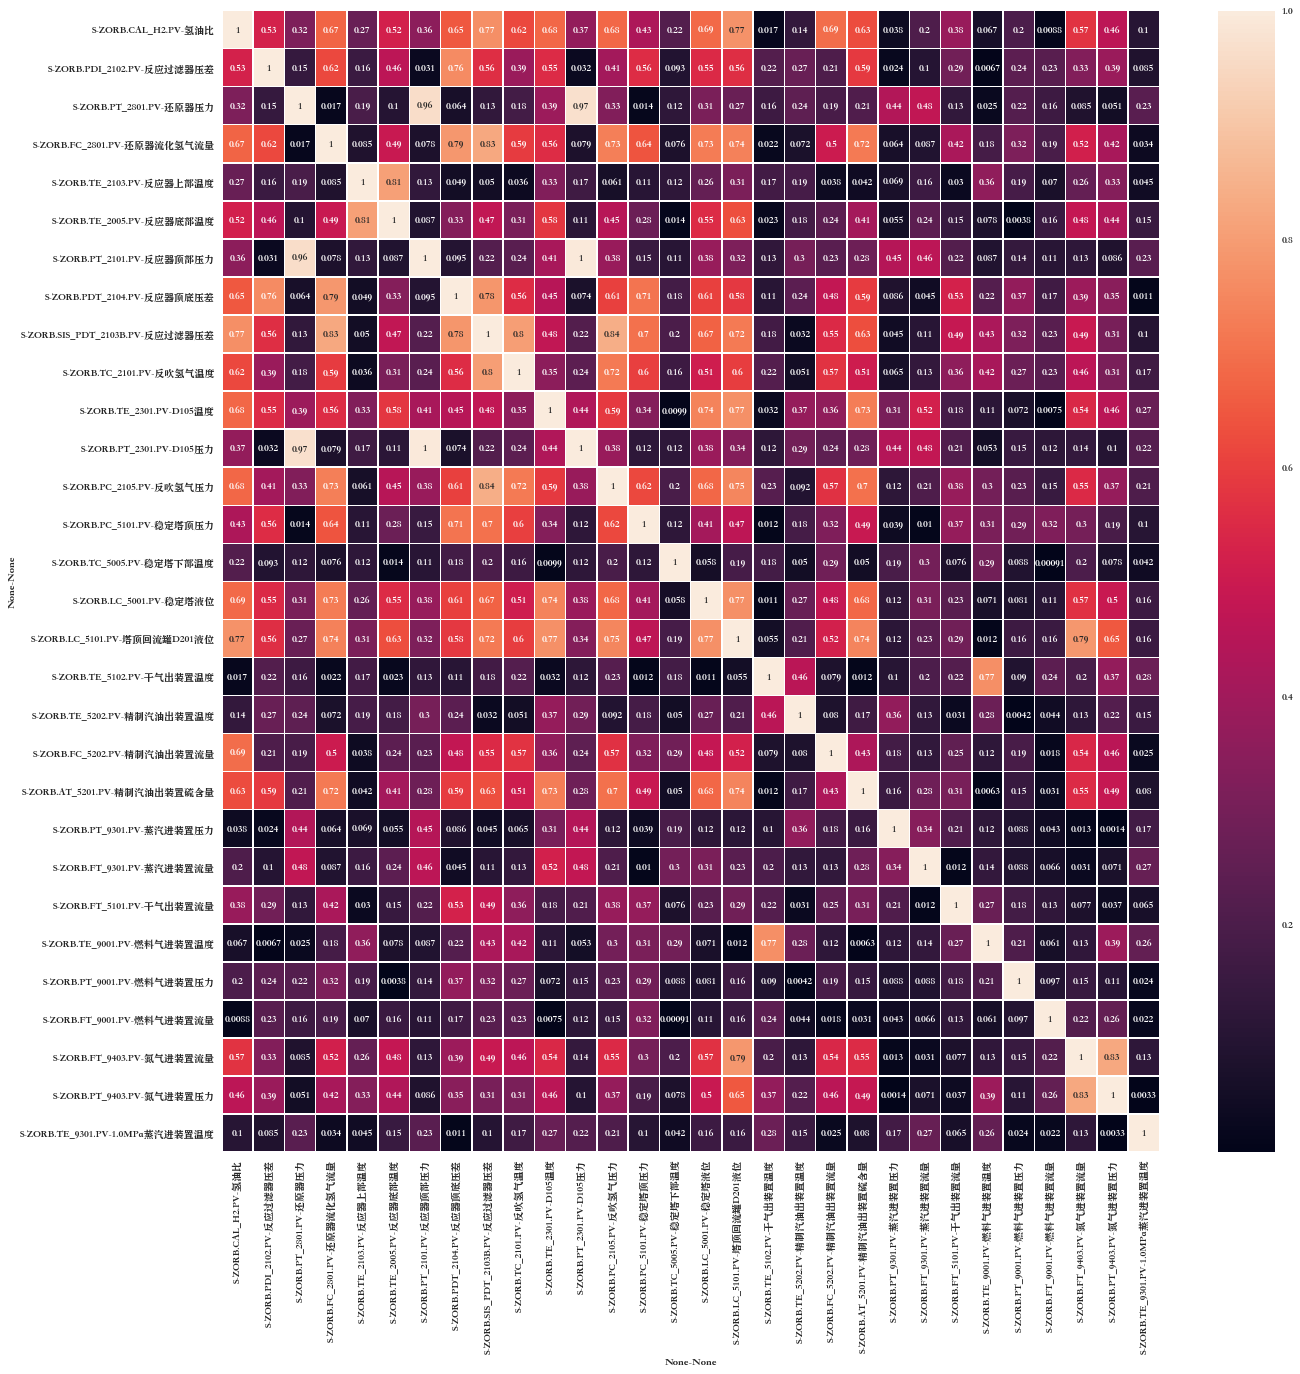

In [4]:
# 计算 操作属性 间的 相关系数 矩阵进行降维
manule_features_corr = manule_features.corr(method='spearman').abs()
# 展示 属性间 相关关系 热力图
fig, ax = plt.subplots(figsize=(21, 21))
sns.heatmap(manule_features_corr.iloc[:30, :30], annot=True, linewidths=.5, ax=ax)  # 只取出前 30 个属性作为一个例子

In [5]:
# Upper triangle of correlations
upper = manule_features_corr.where(np.triu(np.ones(manule_features_corr.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

In [7]:
manule_features = manule_features.drop(columns = to_drop)
manule_features.head()

,S-ZORB.CAL_H2.PV,S-ZORB.PDI_2102.PV,S-ZORB.PT_2801.PV,S-ZORB.FC_2801.PV,S-ZORB.TE_2103.PV,S-ZORB.PDT_2104.PV,S-ZORB.TE_2301.PV,S-ZORB.PC_5101.PV,S-ZORB.TC_5005.PV,S-ZORB.LC_5001.PV,...,S-ZORB.TE_1102.DACA,S-ZORB.AT-0001.DACA.PV,S-ZORB.AT-0008.DACA.PV,S-ZORB.AT-0012.DACA.PV,S-ZORB.AT-0013.DACA.PV,S-ZORB.FT_1204.DACA.PV,S-ZORB.CAL.LINE.PV,S-ZORB.CAL.LEVEL.PV,S-ZORB.FT_1504.DACA.PV,cluster
,氢油比,反应过滤器压差,还原器压力,还原器流化氢气流量,反应器上部温度,反应器顶底压差,D105温度,稳定塔顶压力,稳定塔下部温度,稳定塔液位,...,E-101壳程入口总管温度,S_ZORB AT-0001,S_ZORB AT-0008,S_ZORB AT-0012,S_ZORB AT-0013,D-121含硫污水排量,反应器线速,反应器料位,8.0MPa氢气至反吹氢压缩机出口,
324,0.238883,18.426142,2.396758,821.718908,425.160278,57.791767,322.651488,0.650008,130.444508,50.148594,...,427.375517,0.556529,0.696293,0.219066,0.383900,2.737464,0.296138,78.988005,-13900.46050,2
323,0.235185,18.626541,2.394805,820.887623,426.057338,55.948335,332.060390,0.650045,128.461003,50.037513,...,427.996105,0.556830,0.702123,0.226674,0.389345,61.547225,0.296251,79.181882,-12373.27275,2
322,0.237478,18.477196,2.398691,818.246100,425.390800,54.764742,331.653440,0.650000,129.190320,50.104367,...,428.094835,0.544487,0.700053,0.233229,0.388347,53.357489,0.295287,79.441724,-10846.08550,2
321,0.239947,18.356451,2.393195,820.912883,425.062968,54.426241,317.072950,0.650016,128.702355,49.977052,...,426.692072,0.535388,0.690537,0.227387,0.387602,76.606090,0.295703,79.461877,-8555.30420,2
320,0.238174,18.169647,2.392515,819.708705,424.567210,52.717846,335.447328,0.650065,129.157865,50.009071,...,426.765535,0.545854,0.686061,0.252780,0.403654,53.423653,0.295308,79.398457,-7028.11670,2


In [8]:
print(source_features.reindex().shape)
print(produc_features.reindex().shape)
print(manule_features.reindex().shape)

(119, 7)
(119, 3)
(119, 137)


In [9]:
y = produc_features[('产品性质', 'RON损失\n（不是变量）')].to_numpy()
X = manule_features.to_numpy()

In [10]:
# 使用 T-SNE 进行数据降维
# X是特征，不包含target; X_tsne 是已经降维之后的特征
# 指定降维后的维数
re_dimension = int(manule_features.shape[1]/3)  # 需要调整的参数
relate_features = set()
max_iter = 60
num_iter = 0
tsne = manifold.TSNE(n_components=re_dimension, perplexity=6, n_iter=6000, init='pca', method="exact")
features_pool = list(set(manule_features.keys().to_numpy()))
choice_feature = random.choice(features_pool)

while len(relate_features) <= 30 and num_iter <= max_iter:
    X_tsne = tsne.fit_transform(manule_features[list(set(features_pool).difference(set(choice_feature)))].to_numpy())
    print(f"num_iter => {num_iter} 原始样本数据维度 {X.shape[-1]}. t-SNE降维后的数据维度 {X_tsne.shape[-1]}")
    tSNE_features = pd.DataFrame(data=X_tsne, columns=[f'feature_{x + 1}' for x in range(re_dimension)])
    tSNE_features_full = tSNE_features.join(samples_data[[('产品性质', 'RON损失\n（不是变量）')]])
    tSNE_features_full_corr = tSNE_features_full.corr(method='spearman').abs().replace(1.0, np.nan)
    tSNE_feature = tSNE_features_full_corr[('产品性质', 'RON损失\n（不是变量）')].idxmax()
    combine_features = manule_features[features_pool].join(pd.DataFrame(data=tSNE_features[[tSNE_feature]].values, columns=[('t-SNE', 'max-relative')]))
    combine_features_corr = combine_features.corr(method='spearman').abs().replace(1.0, np.nan)
    choice_feature = combine_features_corr[('t-SNE', 'max-relative')].idxmax()
    relate_features.add(choice_feature)
    features_pool.remove(choice_feature)
    num_iter += 1

print(relate_features)

num_iter => 0 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 1 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 2 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 3 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 4 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 5 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 6 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 7 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 8 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 9 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 10 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 11 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 12 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 13 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 14 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 15 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 16 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 17 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 18 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 19 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 20 原始样本数据维度 137. t-SNE降维后的数据维度 45
num_iter => 21 原始样本数据维度 137. t-SNE降维后的数据维度 4

In [11]:
# 增加题目要求的变量作为建模属性
model_features = manule_features[list(relate_features)].join(source_features[('原料性质', '辛烷值RON')])
model_features = model_features.join(datetime_features)
model_features.describe()

,S-ZORB.LT_2901.DACA,S-ZORB.FT_2433.DACA,S-ZORB.TE_5004.DACA,S-ZORB.PC_1301.PV,S-ZORB.LC_1202.PV,S-ZORB.TE_9301.PV,S-ZORB.FT_9102.PV,S-ZORB.FC_5103.DACA,S-ZORB.DT_2001.DACA,S-ZORB.FC_2601.PV,...,S-ZORB.PDI_2102.PV,S-ZORB.FT_9201.PV,S-ZORB.PT_9001.PV,S-ZORB.LC_2601.DACA,S-ZORB.FT_9401.PV,S-ZORB.PT_2901.DACA,S-ZORB.TE_7106B.DACA,S-ZORB.PT_9402.PV,原料性质,时间
,D-109吸附剂料位,D-106压力仪表管嘴反吹气流量,稳定塔顶出口温度,K101机出口压力,D121液面,1.0MPa蒸汽进装置温度,火炬气排放流量,稳定塔顶回流流量,R-101下部床层压降,R102再生器提升氮气流量,...,反应过滤器压差,循环水进装置流量,燃料气进装置压力,R-102床层吸附剂料位密度,净化风进装置流量,ME-103反吹气总管压力,K-101B左排气温度,非净化风进装置压力,辛烷值RON,Unnamed: 1_level_1
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,1.190000e+02,119.000000,119.000000,119.000000,...,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,1.190000e+02
mean,24.502660,4.906480,62.395750,3.136357,50.036597,200.027135,2.243032e+06,9331.562690,53.755274,73.855063,...,22.045219,441.432754,0.404929,66.138102,100.963523,544.671857,36.852428,0.619889,0.238329,1.530359e+18
std,17.572360,0.527248,5.933111,0.062586,0.164594,10.732005,5.343047e+06,3542.971116,25.257567,10.774374,...,3.134857,28.346013,0.020917,11.217629,22.570480,12.898623,19.190487,0.016407,0.747074,2.819263e+16
min,-0.018297,3.514823,42.537079,2.997825,49.699286,178.392130,2.841478e+01,719.758145,0.306759,2.701256,...,11.350653,336.798185,0.366904,50.852419,29.951170,499.136383,5.285085,0.575532,-2.186326,1.492416e+18
25%,9.695996,4.514398,60.091141,3.080150,49.987695,192.169675,1.214965e+02,6713.770400,48.941680,69.392410,...,20.212878,424.034480,0.396127,55.908190,103.886933,537.848039,22.074575,0.610577,-0.314203,1.504987e+18
50%,20.487778,4.990259,63.948869,3.121058,50.004354,198.157350,2.524360e+02,9416.543775,52.689550,73.659658,...,21.438785,439.633345,0.405314,67.534727,108.224044,545.589970,30.332180,0.617054,0.196377,1.519978e+18
75%,37.596274,5.246137,67.166538,3.199913,50.017384,207.407140,6.113059e+02,11575.526875,74.606733,79.900769,...,24.257229,462.569517,0.411612,69.576592,111.869187,551.328278,56.479675,0.627920,0.706956,1.557346e+18
max,66.512932,6.385161,71.818214,3.222043,50.858507,231.096315,1.856827e+07,20598.232000,87.707713,96.798192,...,30.727688,499.036752,0.526170,91.660846,125.566625,570.370963,66.725104,0.659406,2.011769,1.583482e+18


In [12]:
weight_2nd = manule_features.shape[0]/samples_features.shape[0]
model_features_2nd = model_features
produc_features_2nd = produc_features
%store model_features_2nd
%store produc_features_2nd
%store weight_2nd

Stored 'model_features_2nd' (DataFrame)
Stored 'produc_features_2nd' (DataFrame)
Stored 'weight_2nd' (float)
